This project aims to develop a predictive model to determine if it will rain on the following day, using wind information.

For this purpose, the city of Adelaide was chosen to verify the relationship between wind and rain. It was also verified if this relationship was present in different cities, in this exemple, it was verified if the winds of Melbourne influenced the rains in Adelaide.

Dependencies:

Python 3.7.4

Pandas 0.25.1

NumPy 1.16.5

Sklearn 0.22.1

MatplotLib 3.1.1

IPython: 7.8.0

In [1]:
# Import libraries

import pandas as pd
import numpy as np
# Produces a prediction model in the form of an ensemble of weak prediction models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from time import time
from sklearn.metrics import f1_score
# Standardising the data
from sklearn.preprocessing import scale
# Time Series cross-validator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
# Displayd data
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

Read data from cvs file

In [2]:
data = pd.read_csv('rain_data_aus.csv')

Data prep

In [3]:
# Remove all rows with NaN in columns 'raintoday' and 'raintomorrow'
data['raintoday'].dropna(axis=0) 
data['raintomorrow'].dropna(axis=0)

# Replace 'No' and 'Yes' by 0 and 1, respectively
data = data.replace(to_replace=['No', 'Yes'], value=[0, 1])
# Sort dates
data['date'] = pd.to_datetime(data.date)
data = data.sort_values(by='date')

# Visualize 
print(data.shape)
display(data.head(3)) 
display(data.tail(3))

(142193, 23)


,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
44351,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,68.0,29.0,1019.7,...,14.4,23.6,0.0,3.6,1,31.16,36.8,11,9.613089,0.538687
44352,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,80.0,36.0,1012.4,...,17.5,25.7,1.0,3.6,1,34.28,45.2,9,17.115142,0.445920
44353,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,82.0,69.0,1009.5,...,15.4,20.2,1.0,39.8,1,30.08,84.8,11,17.391294,0.861744


,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
29496,2017-06-25,Richmond,2.7,20.0,0.2,NaN,NaN,88.0,35.0,1018.8,...,9.6,19.4,0.0,0.0,0,26.000000,44.0,13,5.257638,0.054258
26545,2017-06-25,Penrith,3.1,20.0,0.0,NaN,NaN,95.0,45.0,NaN,...,7.8,17.8,0.0,0.0,0,26.000000,56.0,10,15.136587,0.070515
35838,2017-06-25,SydneyAirport,6.8,19.5,0.0,3.4,9.4,67.0,42.0,1018.4,...,11.9,17.9,0.0,0.0,0,2.742626,52.4,7,12.327163,0.026886


Read wind data from cvs files

In [4]:
# It was removes the '_' character from the datasets columns'  'wind_table_01.csv' and 'wind_table_02.csv',
# for matching with the other datasets


w1 = pd.read_csv('wind_table_01.csv')
w2 = pd.read_csv('wind_table_02.csv')
w3 = pd.read_csv('wind_table_03.csv')
w4 = pd.read_csv('wind_table_04.csv')
w5 = pd.read_csv('wind_table_05.csv')
w6 = pd.read_csv('wind_table_06.csv')
w7 = pd.read_csv('wind_table_07.csv')
w8 = pd.read_csv('wind_table_08.csv')

frames = [w1, w2, w3, w4, w5, w6, w7, w8]
wind = pd.concat(frames, ignore_index=True)

Data prep

In [5]:
# Replace directions strings by numbers 
wind = wind.replace(to_replace=['N',
                                'NNE',
                                'NE',
                                'ENE',
                                'E',
                                'ESE',
                                'SE',
                                'SSE',
                                'S',
                                'SSW',
                                'SW',
                                'WSW',
                                'W',
                                'WNW',
                                'NW',                                
                                'NNW'], value=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# Sort dates
wind['date'] = pd.to_datetime(wind.date)
wind = wind.sort_values(by='date')

# Visualize 
print(wind.shape)
display(wind.head(3)) 
display(wind.tail(3))

(164386, 8)


,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2007-11-01,Canberra,15.0,30.0,11.0,15.0,6.0,20.0
1,2007-11-02,Canberra,4.0,39.0,5.0,13.0,4.0,17.0
2,2007-11-03,Canberra,15.0,85.0,1.0,2.0,6.0,6.0


,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
142174,2017-06-25,Melbourne,15.0,35.0,1.0,16.0,13.0,17.0
142172,2017-06-25,Sale,NaN,NaN,14.0,15.0,6.0,31.0
164385,2017-06-25,Launceston,15.0,50.0,16.0,16.0,15.0,17.0


Select two cities

In [6]:
city_1 = data.loc[data['location'] == "Adelaide"]
city_2 = data.loc[data['location'] == "Melbourne"]

w1 = wind.loc[wind['location'] == "Adelaide"]
w2 = wind.loc[wind['location'] == "Melbourne"]

city_1 = city_1.reset_index()
city_2 = city_2.reset_index()
w1     = w1.reset_index()
w2     = w2.reset_index()

print ("City 1 - Adelaide data shape: ", city_1.shape)
print ("City 2 - Melbourne data shape: ", city_2.shape)

print ("Wind city 1 - Adelaide data shape: ", w1.shape)
print ("Wind city 2 - Melbourne data shape: ", w2.shape)

City 1 - Adelaide data shape:  (3090, 24)
City 2 - Melbourne data shape:  (2435, 24)
Wind city 1 - Adelaide data shape:  (3549, 9)
Wind city 2 - Melbourne data shape:  (2857, 9)


Concatenate Adelaide's desired outputs with Adelaide's wind information

In [7]:
wind_w1 = w1
wind_w1["raintomorrow"] = np.nan

city_wind_1 = []

for k in range( len(city_1) ) : 
    value = w1.loc[wind_w1['date'] == city_1['date'][k]]
    value['raintomorrow'] = city_1['raintomorrow'][k] 
    if len(city_wind_1)== 0 :
        city_wind_1 = value
    else:
        frames = [city_wind_1, value]
        city_wind_1 = pd.concat(frames, ignore_index=True)
        
print(len(city_wind_1))
display(city_wind_1.head(3)) 
display(city_wind_1.tail(3))

C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


3549


,index,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,raintomorrow
0,398,2008-07-01,Adelaide,15.0,48.0,11.0,13.0,13.0,15.0,0
1,406,2008-07-02,Adelaide,11.0,35.0,10.0,11.0,13.0,15.0,0
2,414,2008-07-03,Adelaide,13.0,20.0,2.0,11.0,2.0,11.0,0


,index,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,raintomorrow
3546,164281,2017-06-23,Adelaide,16.0,19.0,4.0,15.0,4.0,4.0,0
3547,164330,2017-06-24,Adelaide,13.0,17.0,NaN,11.0,0.0,9.0,0
3548,142137,2017-06-24,Adelaide,13.0,17.0,NaN,11.0,0.0,9.0,0


Concatenate Adelaide's desired outputs with Melbourne's wind information

In [8]:
wind_w2 = w2
wind_w2["raintomorrow"] = np.nan

city_wind_2 = []

for k in range( len(city_1) ) : 
    value = w2.loc[wind_w2['date'] == city_1['date'][k]]
    value['raintomorrow'] = city_1['raintomorrow'][k] 
    if len(city_wind_2)== 0 :
        city_wind_2 = value
    else:
        frames = [city_wind_2, value]
        city_wind_2 = pd.concat(frames, ignore_index=True)
        
print(len(city_wind_2))
display(city_wind_2.head(3)) 
display(city_wind_2.tail(3))

C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2805


,index,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,raintomorrow
0,396,2008-07-01,Melbourne,13.0,63.0,13.0,13.0,37.0,35.0,0
1,404,2008-07-02,Melbourne,13.0,63.0,13.0,12.0,30.0,35.0,0
2,412,2008-07-03,Melbourne,13.0,39.0,13.0,13.0,17.0,24.0,0


,index,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,raintomorrow
2802,164271,2017-06-23,Melbourne,16.0,44.0,1.0,1.0,17.0,19.0,0
2803,164320,2017-06-24,Melbourne,11.0,30.0,14.0,9.0,11.0,2.0,0
2804,142127,2017-06-24,Melbourne,11.0,30.0,14.0,9.0,11.0,2.0,0


Visualize data from city 1

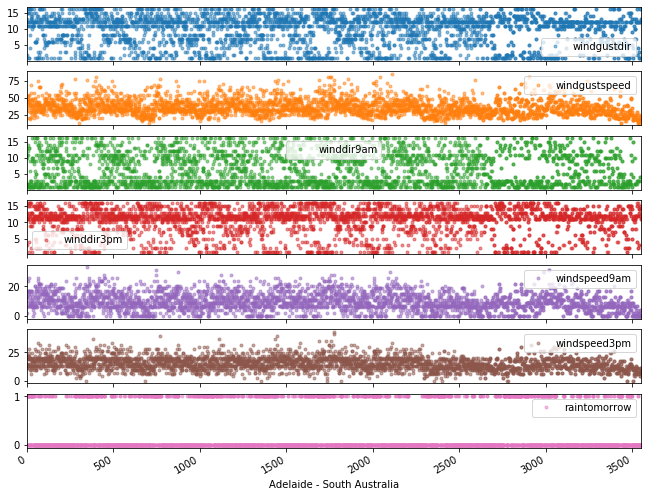

In [9]:
cols_plot = ['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am','windspeed3pm','raintomorrow']
axes = city_wind_1[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Adelaide - South Australia')

City 1: data prep update

In [10]:
# Interpolate NaN values according to ‘nearest’ method 
city_wind_1 = city_wind_1.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_wind_1 = city_wind_1.dropna(axis=0)

Dealing with imbalanced data

In [11]:
# Separate input features and target
X = city_wind_1.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_wind_1['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_wind_1[city_wind_1['raintomorrow'] == 0]
res_1 = city_wind_1[city_wind_1['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_wind_1 = pd.concat([res_0, new_dataset])

print ("City 1 - Adelaide new data shape: ", city_wind_1.shape)

(2754, 10) (795, 10)
City 1 - Adelaide new data shape:  (5508, 10)


Visualize data from city 2

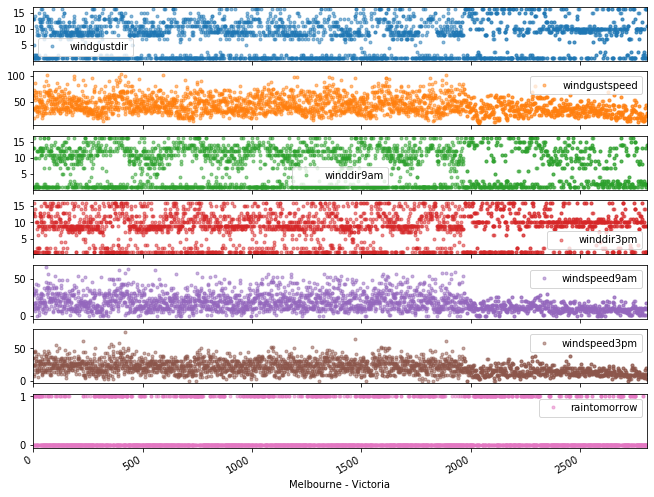

In [12]:
cols_plot = ['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am','windspeed3pm','raintomorrow']
axes = city_wind_2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Melbourne - Victoria')

City 2: data prep update

In [13]:
# Interpolate NaN values according to ‘nearest’ method 
city_wind_2 = city_wind_2.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_wind_2 = city_wind_2.dropna(axis=0)

Dealing with imbalanced data

In [14]:
# Separate input features and target
X = city_wind_2.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_wind_2['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_wind_2[city_wind_2['raintomorrow'] == 0]
res_1 = city_wind_2[city_wind_2['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_wind_2 = pd.concat([res_0, new_dataset])

print ("City 2 - Melbourne new data shape: ", city_wind_2.shape)

(2172, 10) (633, 10)
City 2 - Melbourne new data shape:  (4344, 10)


City 1: verify correlation beteween Adelaide's data

In [15]:
# Remove non applicable data
X_11 = city_wind_1.drop(['index','date', 'location'],1)
corr = X_11.corr()
corr.style.background_gradient(cmap='coolwarm')

,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,raintomorrow
windgustdir,1,0.135258,0.204468,0.505573,0.084203,0.253395,0.0736411
windgustspeed,0.135258,1,0.160064,0.0331459,0.672878,0.669839,0.391038
winddir9am,0.204468,0.160064,1,0.131522,0.14271,0.159851,-7.25203e-05
winddir3pm,0.505573,0.0331459,0.131522,1,0.0333159,0.208674,-0.0222961
windspeed9am,0.084203,0.672878,0.14271,0.0333159,1,0.557859,0.27995
windspeed3pm,0.253395,0.669839,0.159851,0.208674,0.557859,1,0.193066
raintomorrow,0.0736411,0.391038,-7.25203e-05,-0.0222961,0.27995,0.193066,1


Identify the correlated data and consider the median (less noise sensitive) of these values

In [16]:
# Correlation 1: 'windgustspeed', 'windspeed9am', 'windspeed3pm'

col_speed_1 = city_wind_1.loc[:,'windgustspeed']
col_speed_2 = city_wind_1.loc[:,'windspeed9am':'windspeed3pm']
col_speed = pd.concat([col_speed_1, col_speed_2], axis=1)
X_11['speed_median'] = col_speed.median(axis=1)

# Remove correlated data and consider median values
X_12 = X_11.drop(['windgustspeed', 'windspeed9am', 'windspeed3pm'],1)
corr = X_12.corr()
corr.style.background_gradient(cmap='coolwarm')

,windgustdir,winddir9am,winddir3pm,raintomorrow,speed_median
windgustdir,1,0.204468,0.505573,0.0736411,0.234645
winddir9am,0.204468,1,0.131522,-7.25203e-05,0.168424
winddir3pm,0.505573,0.131522,1,-0.0222961,0.181019
raintomorrow,0.0736411,-7.25203e-05,-0.0222961,1,0.229754
speed_median,0.234645,0.168424,0.181019,0.229754,1


Separate datasets

In [17]:
# The first training model (X_11) considers all data
X_11 = X_11.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training (X_12) considers the median of correlated data
X_12 = X_12.drop(['raintomorrow'] ,1)  # Remove the output from the main data

y_1 = city_wind_1['raintomorrow'] # Out

Standardize dataset float values

In [18]:
cols = [['windgustspeed', 'windspeed9am', 'windspeed3pm']]  
for col in cols:
    X_11[col]  = scale(X_11[col])
    
cols = [['speed_median']]  
for col in cols:
    X_12[col]  = scale(X_12[col])
    
# Visualize 
display(X_11.head(3)) 
display(X_11.tail(3))

# Visualize 
display(X_12.head(3)) 
display(X_12.tail(3))

,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,speed_median
0,15.0,0.732982,11.0,13.0,0.372899,-0.135031,15.0
1,11.0,-0.297600,10.0,11.0,0.372899,-0.135031,15.0
2,13.0,-1.486732,2.0,11.0,-1.384781,-0.784736,11.0


,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,speed_median
1745,12.0,0.891533,1.0,12.0,1.491423,1.001953,22.0
1711,15.0,0.574431,12.0,15.0,1.012055,1.326806,24.0
2718,14.0,1.208635,15.0,13.0,0.692477,0.677101,20.0


,windgustdir,winddir9am,winddir3pm,speed_median
0,15.0,11.0,13.0,-0.241230
1,11.0,10.0,11.0,-0.241230
2,13.0,2.0,11.0,-0.913646


,windgustdir,winddir9am,winddir3pm,speed_median
1745,12.0,1.0,12.0,0.935498
1711,15.0,12.0,15.0,1.271706
2718,14.0,15.0,13.0,0.599290


Split our data in training and testing dataset

In [19]:
# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_11):
    X_11_train, X_11_test = X_11.iloc[train_index, :], X_11.iloc[test_index,:]
    X_12_train, X_12_test = X_12.iloc[train_index, :], X_12.iloc[test_index,:]    
    y_1_train,  y_1_test  = y_1.iloc[train_index],     y_1.iloc[test_index]

City 2: verify correlation beteween Melbourne's data

In [20]:
# Remove non applicable data
X_21 = city_wind_2.drop(['index','date', 'location'],1)
corr = X_21.corr()
corr.style.background_gradient(cmap='coolwarm')

,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,raintomorrow
windgustdir,1,-0.20298,0.471216,0.47613,-0.225838,-0.150087,-0.177135
windgustspeed,-0.20298,1,-0.215325,-0.131579,0.740777,0.790358,0.278971
winddir9am,0.471216,-0.215325,1,0.396577,-0.268414,-0.143129,-0.191414
winddir3pm,0.47613,-0.131579,0.396577,1,-0.126151,-0.211497,-0.125309
windspeed9am,-0.225838,0.740777,-0.268414,-0.126151,1,0.649842,0.17951
windspeed3pm,-0.150087,0.790358,-0.143129,-0.211497,0.649842,1,0.179815
raintomorrow,-0.177135,0.278971,-0.191414,-0.125309,0.17951,0.179815,1


Identify the correlated data and consider the median (less noise sensitive) of these values

In [21]:
# Correlation 1: 'windgustspeed', 'windspeed9am', 'windspeed3pm'

col_speed_1 = city_wind_2.loc[:,'windgustspeed']
col_speed_2 = city_wind_2.loc[:,'windspeed9am':'windspeed3pm']
col_speed = pd.concat([col_speed_1, col_speed_2], axis=1)
X_21['speed_median'] = col_speed.median(axis=1)

# Remove correlated data and consider median values
X_22 = X_21.drop(['windgustspeed', 'windspeed9am', 'windspeed3pm'],1)
corr = X_22.corr()
corr.style.background_gradient(cmap='coolwarm')

,windgustdir,winddir9am,winddir3pm,raintomorrow,speed_median
windgustdir,1,0.471216,0.47613,-0.177135,-0.235212
winddir9am,0.471216,1,0.396577,-0.191414,-0.233729
winddir3pm,0.47613,0.396577,1,-0.125309,-0.184767
raintomorrow,-0.177135,-0.191414,-0.125309,1,0.192186
speed_median,-0.235212,-0.233729,-0.184767,0.192186,1


Separate datasets

In [22]:
# The first training model (X_21) considers all data
X_21 = X_21.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training (X_22) considers the median of correlated data
X_22 = X_22.drop(['raintomorrow'] ,1)  # Remove the output from the main data

y_2 = city_wind_2['raintomorrow'] # Out

Standardize dataset float values

In [23]:
cols = [['windgustspeed', 'windspeed9am', 'windspeed3pm']]  
for col in cols:
    X_21[col]  = scale(X_21[col])
    
cols = [['speed_median']]  
for col in cols:
    X_22[col]  = scale(X_22[col])
    
# Visualize 
display(X_21.head(3)) 
display(X_21.tail(3))

# Visualize 
display(X_22.head(3)) 
display(X_22.tail(3))

,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,speed_median
0,13.0,0.949110,13.0,13.0,1.534754,1.24738,37.0
1,13.0,0.949110,13.0,12.0,0.942142,1.24738,35.0
2,13.0,-0.438772,13.0,13.0,-0.158424,0.21886,24.0


,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,speed_median
1848,8.0,-0.901399,13.0,9.0,-1.089671,-0.248649,19.0
367,1.0,1.816536,1.0,1.0,2.635319,3.023915,54.0
874,14.0,1.585222,1.0,12.0,0.434188,-0.155148,24.0


,windgustdir,winddir9am,winddir3pm,speed_median
0,13.0,13.0,13.0,1.126777
1,13.0,13.0,12.0,0.953011
2,13.0,13.0,13.0,-0.002700


,windgustdir,winddir9am,winddir3pm,speed_median
1848,8.0,13.0,9.0,-0.437114
367,1.0,1.0,1.0,2.603785
874,14.0,1.0,12.0,-0.002700


Split our data in training and testing dataset

In [24]:
# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_21):
    X_21_train, X_21_test = X_21.iloc[train_index, :], X_21.iloc[test_index,:]
    X_22_train, X_22_test = X_22.iloc[train_index, :], X_22.iloc[test_index,:]    
    y_2_train,  y_2_test  = y_2.iloc[train_index],     y_2.iloc[test_index]

In [25]:
# Makes predictions using a fit classifier based on F1 score
def predict_labels(clf, features, target):
    
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred), sum(target == y_pred) / float(len(y_pred))

# Fits a classifier to the training data
def train_classifier(clf, X_train, y_train):
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    trained_time = end - start
    print ("Trained time = {:.4f} s".format(trained_time))
    
    return trained_time

# Train and predict using a classifer based on F1 score
def train_predict(clf, X_train, y_train, X_test, y_test):
        
    print(clf.__class__.__name__)
    
    # Train the classifier
    trained_time = train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    train_f1, train_acc = predict_labels(clf, X_train, y_train)
    
    print ("Training F1 score = {:.4f}".format(train_f1))
    print ("Training accuracy = {:.4f}".format(train_acc))
    
    test_f1, test_acc = predict_labels(clf, X_test, y_test)
    
    print ("Test F1 score = {:.4f}".format(test_f1))
    print ("Test accuracy = {:.4f}".format(test_acc))
    
    return trained_time, train_f1, train_acc, test_f1, test_acc 

Results

In [30]:
clf_A = LogisticRegression(random_state = 42)
clf_C = SVC(random_state = 912, kernel='rbf')

print('------------')
print('Adelaide x Adelaide')
print ('')

print('All data')
print ('')
A_X11_trained_time, A_X11_train_f1, A_X11_train_acc, A_X11_test_f1, A_X11_test_acc = train_predict(clf_A, X_11_train, y_1_train, X_11_test, y_1_test)
print ('')
C_X11_trained_time, C_X11_train_f1, C_X11_train_acc, C_X11_test_f1, C_X11_test_acc = train_predict(clf_C, X_11_train, y_1_train, X_11_test, y_1_test)
print ('')

print('Median of correlated data')
print ('')
A_X12_trained_time, A_X12_train_f1, A_X12_train_acc, A_X12_test_f1, A_X12_test_acc = train_predict(clf_A, X_12_train, y_1_train, X_12_test, y_1_test)
print ('')
C_X12_trained_time, C_X12_train_f1, C_X12_train_acc, C_X12_test_f1, C_X12_test_acc = train_predict(clf_C, X_12_train, y_1_train, X_12_test, y_1_test)
print ('')


print('------------')
print('Adelaide x Melborne')
print ('')

print('All data')
print ('')
A_X21_trained_time, A_X21_train_f1, A_X21_train_acc, A_X21_test_f1, A_X21_test_acc = train_predict(clf_A, X_21_train, y_2_train, X_21_test, y_2_test)
print ('')
C_X21_trained_time, C_X21_train_f1, C_X21_train_acc, C_X21_test_f1, C_X21_test_acc = train_predict(clf_C, X_21_train, y_2_train, X_21_test, y_2_test)
print ('')

print('Median of correlated data')
print ('')
A_X22_trained_time, A_X22_train_f1, A_X22_train_acc, A_X22_test_f1, A_X22_test_acc = train_predict(clf_A, X_22_train, y_2_train, X_22_test, y_2_test)
print ('')
C_X22_trained_time, C_X22_train_f1, C_X22_train_acc, C_X22_test_f1, C_X22_test_acc = train_predict(clf_C, X_22_train, y_2_train, X_22_test, y_2_test)
print ('')

------------
Adelaide x Adelaide

All data

LogisticRegression
Trained time = 0.0520 s
Training F1 score = 0.4896
Training accuracy = 0.7325
Test F1 score = 0.5574
Test accuracy = 0.3863

SVC
Trained time = 0.5744 s
Training F1 score = 0.4964
Training accuracy = 0.7427
Test F1 score = 0.5328
Test accuracy = 0.3631

Median of correlated data

LogisticRegression
Trained time = 0.0170 s
Training F1 score = 0.2596
Training accuracy = 0.6906
Test F1 score = 0.2559
Test accuracy = 0.1467

SVC
Trained time = 0.5904 s
Training F1 score = 0.3710
Training accuracy = 0.7144
Test F1 score = 0.3923
Test accuracy = 0.2440

------------
Adelaide x Melborne

All data

LogisticRegression
Trained time = 0.0540 s
Training F1 score = 0.4150
Training accuracy = 0.7032
Test F1 score = 0.4779
Test accuracy = 0.3140

SVC
Trained time = 0.5714 s
Training F1 score = 0.4506
Training accuracy = 0.7133
Test F1 score = 0.5093
Test accuracy = 0.3416

Median of correlated data

LogisticRegression
Trained time = 0.020

Plot city 1 results

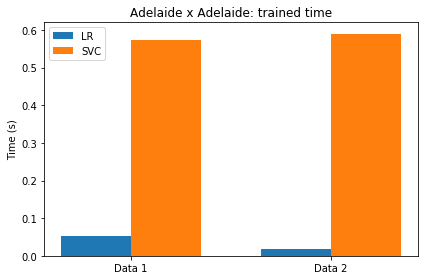

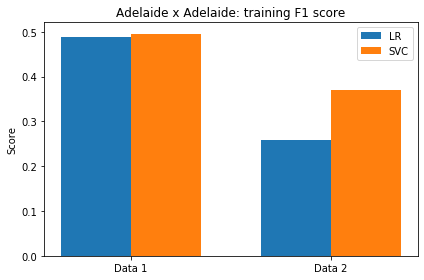

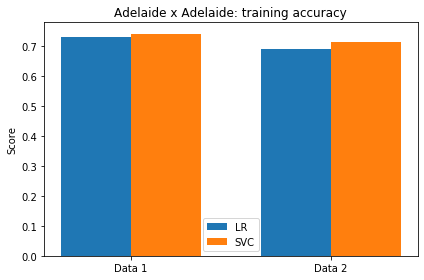

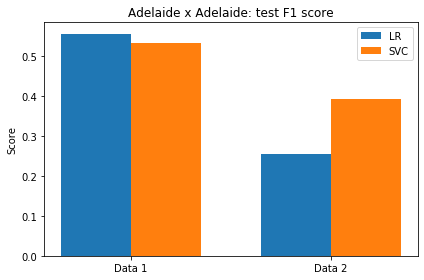

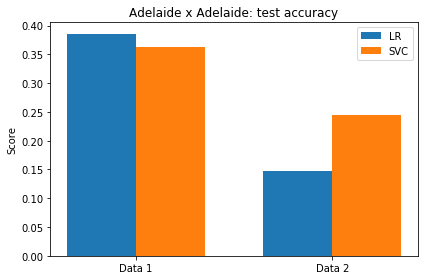

In [31]:
# Plot city 1 results

labels = ['Data 1', 'Data 2']
x1 = [A_X11_trained_time, A_X12_trained_time]
x3 = [C_X11_trained_time, C_X12_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Adelaide x Adelaide: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X11_train_f1, A_X12_train_f1]
x3 = [C_X11_train_f1, C_X12_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Adelaide: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X11_train_acc, A_X12_train_acc]
x3 = [C_X11_train_acc, C_X12_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Adelaide: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X11_test_f1, A_X12_test_f1]
x3 = [C_X11_test_f1, C_X12_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Adelaide: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X11_test_acc, A_X12_test_acc]
x3 = [C_X11_test_acc, C_X12_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Adelaide: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Plot city 2 results

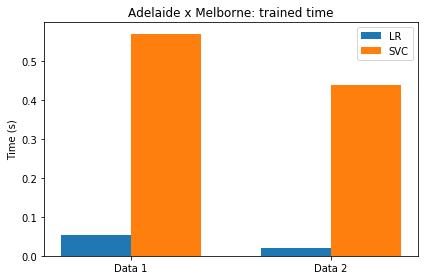

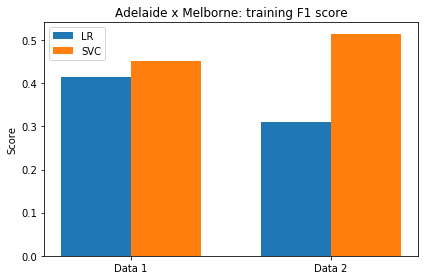

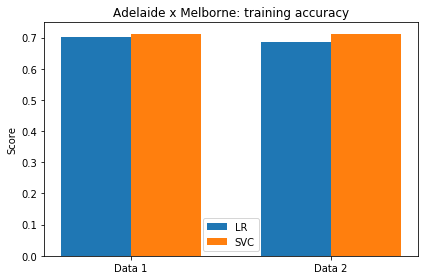

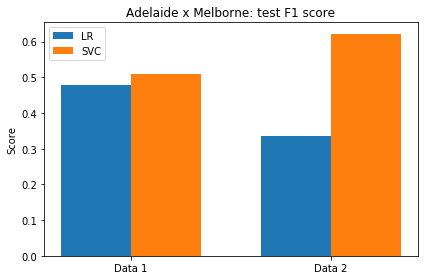

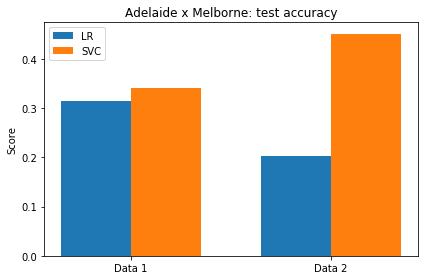

In [32]:
labels = ['Data 1', 'Data 2']
x1 = [A_X21_trained_time, A_X22_trained_time]
x3 = [C_X21_trained_time, C_X22_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Adelaide x Melborne: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X21_train_f1, A_X22_train_f1]
x3 = [C_X21_train_f1, C_X22_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Melborne: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X21_train_acc, A_X22_train_acc]
x3 = [C_X21_train_acc, C_X22_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Melborne: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X21_test_f1, A_X22_test_f1]
x3 = [C_X21_test_f1, C_X22_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Melborne: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2']
x1 = [A_X21_test_acc, A_X22_test_acc]
x3 = [C_X21_test_acc, C_X22_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide x Melborne: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()